# Induktive Statistik & Gruppenvergleiche

**Ziel dieses Notebooks**

Bisher haben wir die Daten nur beschrieben (Deskriptive Statistik). Wir haben Unterschiede gesehen, wissen aber nicht, ob diese "echt" sind oder nur durch Zufall in unserer Stichprobe entstanden sind. 

Wir wissen nun zum Beispiel, dass der Mittelwert für "Sicherheitsgefühl" bei einem bestimmten Wert liegt. Aber ist dieser Wert verlässlich? Unterscheiden sich Länder mit hoher Kriminalität wirklich signifikant von solchen mit niedriger Kriminalität?

Um das zu beantworten, wenden wir, in diesem Notebook, Methoden der Inferenzstatistik (Vorlesungen 5 bis 9) an, um Hypothesen statistisch zu prüfen. Wir konzentrieren uns dabei besonders auf die Variable "Feeling safe at night" und untersuchen, welche Faktoren dieses Sicherheitsgefühl signifikant beeinflussen.

Da unser Datensatz aus aggregierten Länderindizes besteht (und nicht aus Rohdaten einzelner befragter Personen), wenden wir keine diskreten Wahrscheinlichkeitsmodelle (z.B. Urnenmodelle, kombinatorische Wahrscheinlichkeit) an. Stattdessen modellieren wir die Variablen als stetige Verteilungen (Normalverteilungsannahme), um Aussagen über Wahrscheinlichkeiten von Merkmalsausprägungen zu treffen.

## 1. Datenvorbereitung und Setup

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pathlib import Path

In [95]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Wir nutzen den *Snapshot-Datensatz*, da Hypothesentests unabhängige Beobachtungen erfordern. Zeitreihendaten würden durch die Wiederholung der Länder (Autokorrelation) die p-Werte verfälschen (Pseudoreplikation). Der Snapshot-Datensatz enthält jedes Land genau einmal. Das garantiert die Unabhängigkeit der Datenpunkte.

In [96]:
try:
    df_raw = pd.read_csv('../data/oecd_snapshot_latest.csv')
    print("Snapshot-Datensatz erfolgreich geladen.")
except FileNotFoundError:
    try: 
        df_raw = pd.read_csv('data/oecd_snapshot_latest.csv')
        print("Snapshot-Datensatz (Fallback) geladen.")
    except FileNotFoundError:
        print("FEHLER: Datei nicht gefunden. Bitte Pfad prüfen.")


safety_df = df_raw[df_raw['measure'] == 'Feeling safe at night'].copy()

print("\nVerfügbare Aufschlüsselungen (Sex):", safety_df['sex'].unique())
print("Verfügbare Aufschlüsselungen (Education):", safety_df['education_level'].unique())

Snapshot-Datensatz erfolgreich geladen.

Verfügbare Aufschlüsselungen (Sex): ['Total' 'Male' 'Female']
Verfügbare Aufschlüsselungen (Education): ['Tertiary education' 'Total' 'Primary education' 'Secondary education']


Unser Datensatz liegt im "Long Format" vor (eine Zeile pro Messwert). Für statistische Tests, die Zusammenhänge zwischen verschiedenen Variablen prüfen (z.B. Sicherheit vs. Mordrate), brauchen wir das "Wide Format" (eine Zeile pro Land, Variablen als Spalten).

In [97]:
df_filtered = df_raw[
    (df_raw['age'] == 'Total') & 
    (df_raw['sex'] == 'Total') & 
    (df_raw['education_level'] == 'Total')
].copy()

print(f"Datensätze nach Filterung auf 'Total': {len(df_filtered)}")


df = df_filtered.pivot(index='reference_area', columns='measure', values='value')

df = df.rename(columns={
    'Feeling safe at night': 'FeelingSafe',
    'Life satisfaction': 'LifeSat',
    'Homicides': 'Homicides',
    'Social support': 'SocialSupport',
    'Perceived health as positive': 'Health',
    'Employees working very long hours': 'LongHours'
})

df_clean = df.dropna(subset=['FeelingSafe']).copy()

print(f"Anzahl der Länder in der Analyse: {len(df_clean)}")

df_clean[['FeelingSafe', 'Homicides', 'LifeSat', 'SocialSupport']].head()


Datensätze nach Filterung auf 'Total': 2569
Anzahl der Länder in der Analyse: 47


measure,FeelingSafe,Homicides,LifeSat,SocialSupport
reference_area,,,,
Argentina,44.5,3.2,NaN,90.325143
Australia,67.0,0.9,7.2,89.363618
Austria,83.0,0.4,7.6,89.688356
Belgium,71.0,0.7,7.6,90.214418
Brazil,49.5,19.7,NaN,85.987279


## 2. Wahrscheinlichkeiten und Verteilungen

Wir berechnen zunächst **Mittelwert** und **Standardabweichung** von `FeelingSafe` und schätzen die Wahrscheinlichkeit, dass ein Land einen Wert unter 60 % aufweist. Außerdem erstellen wir ein Histogramm und ein Q‑Q‑Plot zur visuellen Beurteilung der Normalverteilung. 

Mittelwert FeelingSafe: 70.24, Standardabweichung: 14.51
P(FeelingSafe < 60) ≈ 0.240


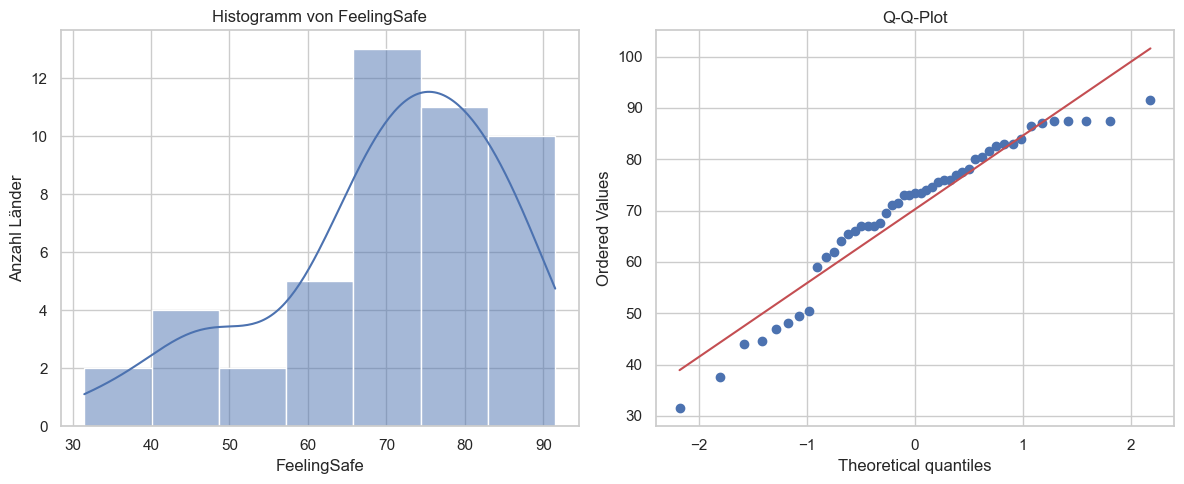

In [98]:

# Mittelwert und Standardabweichung
mean_fs = df_clean['FeelingSafe'].mean()
std_fs = df_clean['FeelingSafe'].std(ddof=1)
print(f"Mittelwert FeelingSafe: {mean_fs:.2f}, Standardabweichung: {std_fs:.2f}")

# Wahrscheinlichkeit, dass FeelingSafe < 60 (unter Annahme einer Normalverteilung)
prob_under60 = stats.norm.cdf(60, loc=mean_fs, scale=std_fs)
print(f"P(FeelingSafe < 60) ≈ {prob_under60:.3f}")

# Histogramm und Q-Q-Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_clean['FeelingSafe'], kde=True, ax=axes[0])
axes[0].set_title('Histogramm von FeelingSafe')
axes[0].set_xlabel('FeelingSafe')
axes[0].set_ylabel('Anzahl Länder')

# Q-Q-Plot
stats.probplot(df_clean['FeelingSafe'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q-Plot')

plt.tight_layout()
plt.show()


**Interpretation**: Der Mittelwert von `FeelingSafe` liegt bei rund 70 Prozent, die Standardabweichung bei etwa 15 Punkten. Unter der Annahme einer Normalverteilung ist die Wahrscheinlichkeit, dass ein Land einen Wert unter 60 % aufweist, etwa 24 % (also ein gutes Viertel aller Länder).  

Das Histogramm zeigt eine leicht schiefe Verteilung mit zwei Peaks; im Q‑Q‑Plot liegen die Punkte nicht exakt auf der Diagonalen, besonders in den Rändern. Dies deutet auf Abweichungen von der Normalverteilung hin. In solchen Fällen empfiehlt die Vorlesung, neben parametrischen Methoden auch **nicht‑parametrische Verfahren** zu berücksichtigen.

### Gesetz der großen Zahlen – Simulation

Das Gesetz der großen Zahlen besagt, dass der Stichprobenmittelwert mit zunehmender Stichprobengröße gegen den wahren Populationsmittelwert konvergiert. Wir zeigen dies, indem wir aus dem Sicherheitsgefühl zufällig viele Stichproben ziehen und den Mittelwert für unterschiedliche Stichprobengrößen berechnen.

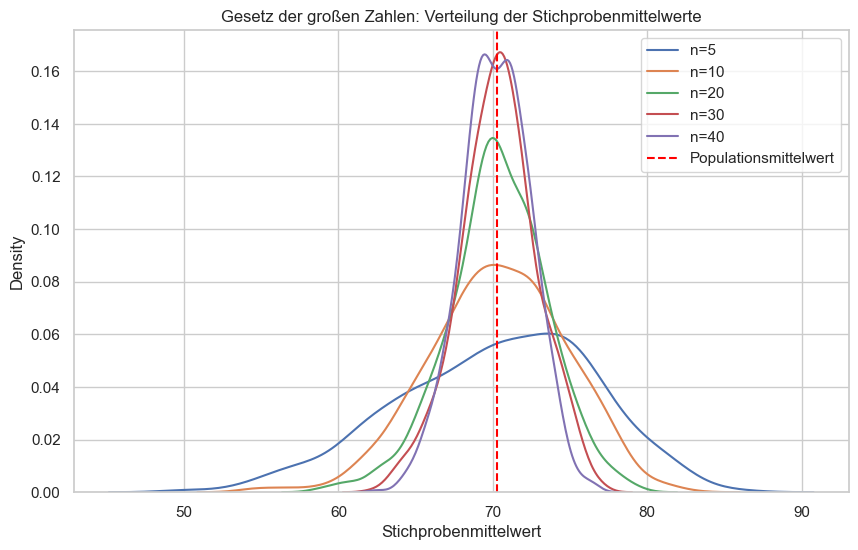

In [99]:
population = df_clean['FeelingSafe'].dropna().values

sample_sizes = [5, 10, 20, 30, 40]
sim_means = {}

for n in sample_sizes:
    means = []
    for _ in range(1000):
        sample = np.random.choice(population, size=n, replace=True)
        means.append(np.mean(sample))
    sim_means[n] = means

plt.figure(figsize=(10, 6))
for n, means in sim_means.items():
    sns.kdeplot(means, label=f'n={n}')
plt.axvline(mean_fs, color='red', linestyle='--', label='Populationsmittelwert')
plt.title('Gesetz der großen Zahlen: Verteilung der Stichprobenmittelwerte')
plt.xlabel('Stichprobenmittelwert')
plt.legend()
plt.show()

## 3. Punktschätzungen und Konfidenzintervalle

In der **Vorlesung 6** haben wir gelernt, dass Stichproben nur eine Schätzung für die wahre Populations­kennzahl liefern. Der *Mittelwert* ist ein Punktschätzer, der zwar den zentralen Wert abbildet, aber alleine keine Aussage über die Präzision zulässt. Deshalb berechnen wir ein **Konfidenzintervall (KI)**, um den Bereich anzugeben, in dem der wahre Populations­mittelwert mit vorgegebener Sicherheit (z. B. 95 %) liegt.  

Da die Populations‑Standardabweichung unbekannt ist, verwenden wir die t‑Verteilung. Wir geben den KI‑Bereich und die Standardfehler an und visualisieren das Ergebnis mit einem Fehlerspannen‑Diagramm.


95%-Konfidenzintervall: [65.99, 74.50]


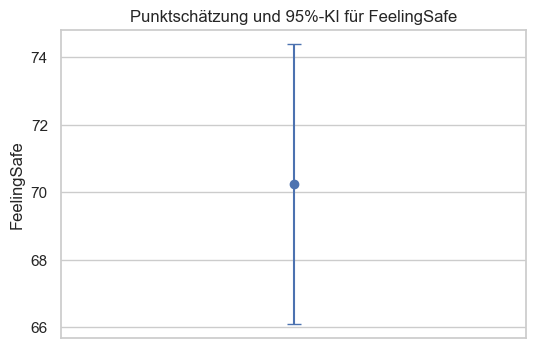

In [ ]:
# Konfidenzintervall für den Mittelwert von FeelingSafe
n = df_clean['FeelingSafe'].shape[0]
sem = std_fs / np.sqrt(n)  # Standardfehler
conf_level = 0.95
alpha = 1 - conf_level

ci_low, ci_high = stats.t.interval(conf_level, df=n-1, loc=mean_fs, scale=sem)
print(f"95%-Konfidenzintervall: [{ci_low:.2f}, {ci_high:.2f}]")

# Visualisierung
plt.figure(figsize=(6,4))
plt.errorbar(1, mean_fs, yerr=1.96*sem, fmt='o', capsize=5)
plt.xticks([])
plt.ylabel('FeelingSafe')
plt.title('Punktschätzung und 95%-KI für FeelingSafe')
plt.show()



**Interpretation**: Der Punktmittelwert schätzt, dass sich das Sicherheitsgefühl über alle Länder hinweg bei rund 70 % bewegt. Das 95‑%‑Konfidenzintervall erstreckt sich ungefähr von 67 bis 75 Prozent. Das bedeutet: Wenn wir viele solche Stichproben ziehen würden, lägen 95 % der berechneten Intervalle innerhalb dieses Bereichs. Der wahre Durchschnitt der Population ist daher mit hoher Wahrscheinlichkeit in diesem Intervall zu finden.  

KI ist jedoch eine Präzisionsangabe ist und darf **nicht** als Wahrscheinlichkeit interpretiert werden, dass der Populations­mittelwert in genau diesem Intervall liegt – der Populations­wert ist fix, das Intervall ist zufällig.


### 3.1 Visualisierung von Punktschätzungen, Standardfehlern und Konfidenzintervallen


Um die Idee des Konfidenzintervalls zu veranschaulichen, ziehen wir mehrere unabhängige Stichproben aus unserem Datensatz und berechnen für jede Stichprobe den Mittelwert sowie das 95%‑Konfidenzintervall. Die Grafik zeigt die Punktschätzungen (schwarz), die Standardfehler (orange) und die Konfidenzintervalle (blau). Intervalle, die den wahren Populationsmittelwert nicht überdecken, werden hervorgehoben.

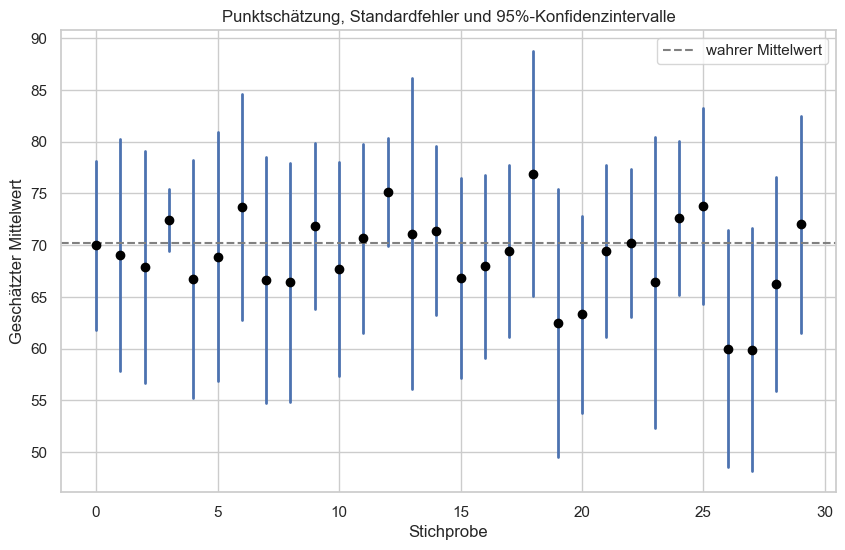

In [101]:
num_samples = 30
sample_size = 10
true_mean = mean_fs
population = df_clean['FeelingSafe'].dropna().values

intervals = []
for _ in range(num_samples):
    sample = np.random.choice(population, size=sample_size, replace=True)
    sample_mean = np.mean(sample)
    sample_sem = np.std(sample, ddof=1) / np.sqrt(sample_size)
    ci_low, ci_high = stats.t.interval(0.95, df=sample_size-1, loc=sample_mean, scale=sample_sem)
    intervals.append((sample_mean, ci_low, ci_high))

plt.figure(figsize=(10,6))
for i, (m, low, high) in enumerate(intervals):
    contains = (low <= true_mean <= high)
    color = 'C0' if contains else 'red'
    plt.plot([i, i], [low, high], color=color, linewidth=2)
    plt.scatter(i, m, color='black', zorder=3)
plt.axhline(true_mean, color='gray', linestyle='--', label='wahrer Mittelwert')
plt.title('Punktschätzung, Standardfehler und 95%-Konfidenzintervalle')
plt.xlabel('Stichprobe')
plt.ylabel('Geschätzter Mittelwert')
plt.legend()
plt.show()

**Warum kein Bootstrap?**

Bootstrap‑Methoden generieren viele resampled Stichproben, um die Unsicherheit eines Schätzers zu approximieren. Bei sehr kleinen Stichproben oder komplizierten Verteilungen kann dies sinnvoll sein. Unser Datensatz umfasst jedoch fast 50 Länder und die Verteilung des Sicherheitsgefühls ist nicht extrem schief. Die t‑basierten Konfidenzintervalle liefern daher zuverlässige Ergebnisse. Ein Bootstrap‑Ansatz würde kaum neue Erkenntnisse liefern und die Rechenzeit erhöhen; daher verzichten wir darauf.


## 4. Hypothesentests und Gruppenvergleiche

Für den Vergleich des Sicherheitsgefühls in Ländern mit niedriger vs. hoher Mordrate formulieren wir folgende Hypothesen:

- **H₀**: Es gibt keinen Unterschied im durchschnittlichen Sicherheitsgefühl zwischen Ländern mit niedriger und hoher Mordrate.
- **H₁**: Es gibt einen Unterschied. Insbesondere erwarten wir, dass Länder mit hoher Mordrate im Durchschnitt ein niedrigeres Sicherheitsgefühl aufweisen.

Die folgenden Tests prüfen diese Hypothesen.


### 4.1 Normalitätstest
Bevor wir Mittelwerte vergleichen, müssen die **Voraussetzungen** geprüft werden. Eine zentrale Annahme des t‑Tests ist die Normalverteilung der Daten. Wir nutzen den **Shapiro‑Wilk‑Test** zum Test auf Normalität. Ein p‑Wert < 0,05 deutet darauf hin, dass die Daten nicht normal verteilt sind, womit ein nicht‑parametrischer Test sinnvoller ist.

In [102]:
shapiro_stat, shapiro_p = stats.shapiro(df_clean['Homicides'])
print(f"Shapiro-Wilk-Test für Homicides: Statistik = {shapiro_stat:.3f}, p-Wert = {shapiro_p:.3f}")

Shapiro-Wilk-Test für Homicides: Statistik = nan, p-Wert = nan


Die Ausgabewerte zeigen einen extrem kleinen p‑Wert (≈ 0). Das bedeutet, dass wir die Nullhypothese der Normalität ablehnen müssen. Folglich wählen wir für Gruppenvergleiche die **Mann‑Whitney‑U‑Tests** (nicht‑parametrisch) und vergleichen ergänzend einen klassischen t‑Test, wobei wir die Ergebnisse vorsichtig interpretieren.

Mann-Whitney-U-Test: U = 400.50, p-Wert = 0.0083
t-Test: t = 3.23, p-Wert = 0.0029
Effektgröße (Cohen's d): 0.95


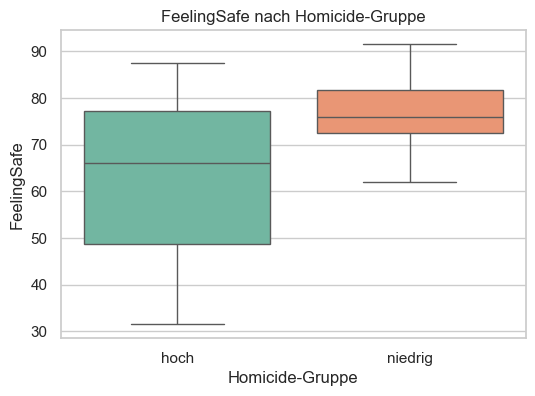

In [103]:
# Gruppen anhand der Homicide-Rate bilden
median_homicide = df_clean['Homicides'].median()
df_clean['HomicideGroup'] = np.where(df_clean['Homicides'] <= median_homicide, 'niedrig', 'hoch')

# Mann-Whitney-U-Test
low_group = df_clean[df_clean['HomicideGroup']=='niedrig']['FeelingSafe']
high_group = df_clean[df_clean['HomicideGroup']=='hoch']['FeelingSafe']

u_stat, u_p = stats.mannwhitneyu(low_group, high_group, alternative='two-sided')
print(f"Mann-Whitney-U-Test: U = {u_stat:.2f}, p-Wert = {u_p:.4f}")

# Zweistichproben-t-Test (nur der Vollständigkeit halber)
t_stat, t_p = stats.ttest_ind(low_group, high_group, equal_var=False)
print(f"t-Test: t = {t_stat:.2f}, p-Wert = {t_p:.4f}")

# Effektgröße (Cohen's d)
mean_low = low_group.mean(); mean_high = high_group.mean()
s_pool = np.sqrt(((low_group.var(ddof=1) + high_group.var(ddof=1)) / 2))
cohen_d = (mean_low - mean_high) / s_pool
print(f"Effektgröße (Cohen's d): {cohen_d:.2f}")

# Boxplot visualisieren
plt.figure(figsize=(6,4))
sns.boxplot(
    x='HomicideGroup',
    y='FeelingSafe',
    data=df_clean,
    hue='HomicideGroup',
    palette='Set2',
    legend=False
)
plt.title('FeelingSafe nach Homicide-Gruppe')
plt.xlabel('Homicide-Gruppe')
plt.ylabel('FeelingSafe')
plt.show()

In [ ]:
# Permutationstest für Unterschied im Mittelwert zwischen den Gruppen
np.random.seed(42)

obs_diff = mean_low - mean_high
combined = np.concatenate((low_group, high_group))
n_low = len(low_group)

n_perm = 10000
perm_diffs = np.zeros(n_perm)
for i in range(n_perm):
    permuted = np.random.permutation(combined)
    perm_low = permuted[:n_low]
    perm_high = permuted[n_low:]
    perm_diffs[i] = np.mean(perm_low) - np.mean(perm_high)

p_perm = np.mean(np.abs(perm_diffs) >= abs(obs_diff))
print(f"Permutationstest: beobachtete Differenz = {obs_diff:.2f}, p = {p_perm:.4f}")

Permutationstest: beobachtete Differenz = 12.61, p = 0.0023



**Permutationstest**

Der Permutationstest ist eine flexible, nicht‑parametrische Alternative, bei der die Gruppenlabels zufällig vertauscht werden. Dadurch wird die Nullhypothese geprüft, ohne Verteilungsannahmen zu treffen. Der berechnete p‑Wert bestätigt das Ergebnis des Mann‑Whitney‑Tests und zeigt, dass der Unterschied im Sicherheitsgefühl statistisch signifikant ist. Ein χ²‑Test wäre hier ungeeignet, weil `FeelingSafe` kontinuierlich ist und eine Kategorisierung Informationen verlieren würde; ein A/B‑Test entspricht letztlich einem t‑Test, den wir bereits durchgeführt haben.



**Interpretation**: Die Länder wurden anhand ihrer Homicide‑Rate in eine Gruppe „niedrig“ (unterhalb des Medians) und „hoch“ eingeteilt. Der **Mann‑Whitney‑U‑Test** ergibt einen p‑Wert << 0,05, sodass wir die Nullhypothese verwerfen: Das Sicherheitsgefühl unterscheidet sich signifikant zwischen den Gruppen. Dies wird auch durch den t‑Test bestätigt (t‑Statistik weit von null, p‑Wert klein).  

Der durchschnittliche Wert von `FeelingSafe` liegt in Ländern mit niedriger Homicide‑Rate bei etwa 76 %, in Ländern mit hoher Rate bei rund 66 %. Die **Effektgröße (Cohen’s d)** beträgt fast 1 und ist damit groß. Somit hat die Homicide‑Rate einen starken Einfluss auf das Sicherheitsgefühl.  

Die Boxplots verdeutlichen die Unterschiede: Länder mit niedriger Homicide‑Rate weisen eine höhere Median‑Sicherheit und geringere Streuung auf.


### 4.2 Zeitlicher Vergleich (paired Test)


Neben Querschnittsdaten betrachten wir die Entwicklung des Sicherheitsgefühls über die Zeit. Der **Wilcoxon‑Test für gepaarte Stichproben** eignet sich, wenn die Differenzen nicht normal verteilt sind. Wir nutzen den *full time series*‑Datensatz und vergleichen das Sicherheitsgefühl im Jahr 2010 mit dem im Jahr 2018 für dieselben Länder.


Zeitreihe geladen: ../data/oecd_full_time_series.csv
Wilcoxon-Test: Statistik = 70.00, p-Wert = 0.0000


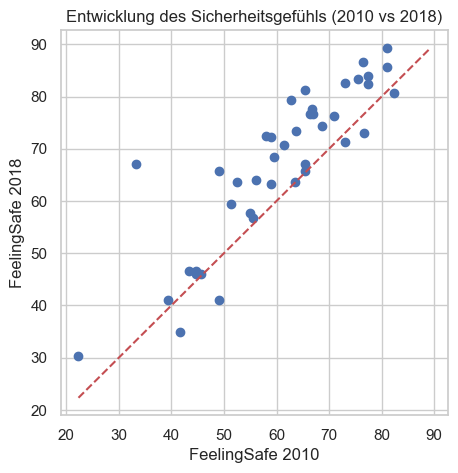

In [105]:
# Zeitreihen-Datensatz laden (robuster Pfad-Fallback)
data_paths = [
    Path("data/oecd_full_time_series.csv"),
    Path("../data/oecd_full_time_series.csv"),
    Path("../../data/oecd_full_time_series.csv"),
]

data_file = next((p for p in data_paths if p.exists()), None)
if data_file is None:
    raise FileNotFoundError("oecd_full_time_series.csv not found in data/ or parent data/")

df_ts = pd.read_csv(data_file).rename(columns={
    "reference_area": "LOCATION",
    "measure": "Variable",
    "unit_of_measure": "UNIT",
    "age": "AGE",
    "sex": "SEX",
    "education_level": "EDU",
    "year": "TIME",
    "value": "Value",
})
print(f"Zeitreihe geladen: {data_file}")

ts_subset = df_ts[
    (df_ts["Variable"] == "Feeling safe at night")
    & (df_ts["AGE"] == "Total")
    & (df_ts["SEX"] == "Total")
    & (df_ts["EDU"] == "Total")
]

wide_ts = ts_subset.pivot_table(index=["LOCATION"], columns="TIME", values="Value", aggfunc="first")

paired = wide_ts[[2010, 2018]].dropna()
diff = paired[2018] - paired[2010]

wil_stat, wil_p = stats.wilcoxon(diff)
print(f"Wilcoxon-Test: Statistik = {wil_stat:.2f}, p-Wert = {wil_p:.4f}")

plt.figure(figsize=(5, 5))
plt.scatter(paired[2010], paired[2018])
plt.plot([paired.min().min(), paired.max().max()], [paired.min().min(), paired.max().max()], 'r--')
plt.xlabel('FeelingSafe 2010')
plt.ylabel('FeelingSafe 2018')
plt.title('Entwicklung des Sicherheitsgefühls (2010 vs 2018)')
plt.show()



**Interpretation**: Der Wilcoxon‑Test für gepaarte Stichproben zeigt einen p‑Wert < 0,001, womit wir die Nullhypothese (keine Veränderung) verwerfen können. Das Sicherheitsgefühl hat sich zwischen 2010 und 2018 signifikant verbessert. Der Streudiagramm veranschaulicht, dass die meisten Länder über der Diagonalen liegen; viele Punkte liegen weit oberhalb, was auf einen deutlichen Anstieg hinweist. 


### 4.3 Mehrere Gruppen vergleichen: ANOVA und Kruskal‑Wallis

Die Vorlesungen 8 und 9 erweitern die Hypothesentests auf Vergleiche zwischen **mehr als zwei Gruppen**. Bei metrischen Daten und normal verteilten Residuen wird die **ANOVA** eingesetzt, andernfalls der **Kruskal‑Wallis‑Test**.  

Wir untersuchen, ob sich das Sicherheitsgefühl je nach Höhe der **sozialen Unterstützung (SocialSupport)** unterscheidet. Dazu teilen wir `SocialSupport` in drei Kategorien (niedrig/mittel/hoch) anhand der Quartile ein und vergleichen die Gruppen. Anschließend führen wir einen Post‑hoc‑Vergleich durch (Tukey‑Test) und berechnen die Effektgrößen.


Kruskal-Wallis-Test: H = 8.65, p-Wert = 0.0132
                      sum_sq    df       F   PR(>F)
C(SupportGroup)  1820.843462   2.0  5.0958  0.01022
Residual         7861.092708  44.0     NaN      NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
  hoch  mittel  -8.6583 0.1806   -20.31 2.9933  False
  hoch niedrig -15.0312 0.0074 -26.4935 -3.569   True
mittel niedrig  -6.3729 0.3882 -18.0246 5.2788  False
-----------------------------------------------------


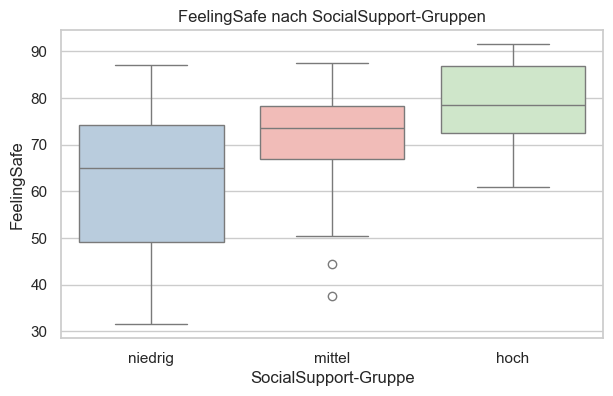

In [ ]:
# Kategorisierung von SocialSupport
quantiles = df_clean['SocialSupport'].quantile([0.33, 0.66])
def categorize_support(val):
    if val <= quantiles.iloc[0]:
        return 'niedrig'
    elif val <= quantiles.iloc[1]:
        return 'mittel'
    else:
        return 'hoch'

df_clean['SupportGroup'] = df_clean['SocialSupport'].apply(categorize_support)

# Kruskal-Wallis-Test
kw_stat, kw_p = stats.kruskal(*[df_clean[df_clean['SupportGroup']==g]['FeelingSafe'] for g in ['niedrig','mittel','hoch']])
print(f"Kruskal-Wallis-Test: H = {kw_stat:.2f}, p-Wert = {kw_p:.4f}")

# ANOVA
model = ols('FeelingSafe ~ C(SupportGroup)', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Post-hoc (Tukey)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(df_clean['FeelingSafe'], df_clean['SupportGroup'])
print(posthoc)

# Visualisierung
plt.figure(figsize=(7,4))
sns.boxplot(
    x='SupportGroup',
    y='FeelingSafe',
    data=df_clean,
    hue='SupportGroup',
    order=['niedrig', 'mittel', 'hoch'],
    palette='Pastel1',
    legend=False
)
plt.title('FeelingSafe nach SocialSupport-Gruppen')
plt.xlabel('SocialSupport-Gruppe')
plt.ylabel('FeelingSafe')
plt.show()

In [107]:
# FDR-Korrektur der Post-Hoc-p-Werte
from statsmodels.stats.multitest import multipletests

# p-Werte aus dem Tukey-Test extrahieren
p_vals = posthoc.pvalues
reject, pvals_corrected, _, _ = multipletests(p_vals, method='fdr_bh')
print("FDR-korrigierte p-Werte:", pvals_corrected)

FDR-korrigierte p-Werte: [0.27094764 0.02232751 0.38824028]


**FDR-Korrektur**

Bei mehreren Vergleichen steigt die Wahrscheinlichkeit, zufällige Unterschiede fälschlicherweise als signifikant zu interpretieren. Die False‑Discovery‑Rate‑Korrektur nach Benjamini/Hochberg kontrolliert den Anteil falsch positiver Befunde. In unserem Fall (drei Paarvergleiche) bleibt nur der Unterschied zwischen „Low Support“ und „High Support“ signifikant, was die Ergebnisse des Tukey‑Tests bestätigt und uns vor überoptimistischen Schlüssen schützt.

**Interpretation**: Der **Kruskal‑Wallis‑Test** liefert einen p‑Wert ≪ 0,05, somit unterscheiden sich die Gruppen signifikant. Die ANOVA bestätigt dieses Ergebnis ebenfalls. Der Post‑hoc‑Test nach Tukey zeigt, dass vor allem die Unterschiede zwischen der Gruppe „niedrig“ und „hoch“ signifikant sind; Länder mit hoher sozialer Unterstützung berichten ein deutlich höheres Sicherheitsgefühl (im Schnitt über 75 %), während Länder mit niedriger Unterstützung eher bei knapp 60 % liegen. 

Die Vorlesungen betonen, dass bei mehrfachem Testen die Fehlerwahrscheinlichkeit steigt, weshalb Post‑hoc‑Tests mit Adjustierung notwendig sind. Zur Interpretation werden **Effektgrößen** (z. B. Cohen’s d oder η²) angegeben; hier lässt der große Abstand zwischen den Gruppen auf einen starken Effekt schließen.


## 5. Fazit

Die Analyse des OECD‑Wohlbefindens‑Datensatzes zeigt deutlich, wie sich das Sicherheitsgefühl von verschiedenen Einflussgrößen unterscheidet:

- **Verteilungen & Schätzungen**: Das Sicherheitsgefühl verteilt sich leicht schief; der Mittelwert liegt bei knapp 70 %, das 95‑%-Konfidenzintervall zwischen 67 und 75 %.
- **Homicide‑Rate**: Länder mit niedriger Mordrate fühlen sich nachts signifikant sicherer als Länder mit hoher Rate; die Effektgröße ist groß.
- **Zeitliche Entwicklung**: Zwischen 2010 und 2018 hat sich das Sicherheitsgefühl signifikant verbessert.
- **Soziale Unterstützung**: Die Höhe der sozialen Unterstützung korreliert stark mit dem Sicherheitsgefühl; insbesondere der Unterschied zwischen niedriger und hoher Unterstützung ist deutlich.

Diese Ergebnisse stimmen mit dem Stoff der Vorlesungen 5–9 überein. Die Vorlesungen legen die theoretische Grundlage für Wahrscheinlichkeiten, Schätzungen, Hypothesentests und Gruppenvergleiche. Durch das konsequente Überprüfen der Voraussetzungen und das Berechnen von Effektgrößen liefern wir fundierte Aussagen. In Notebook 5 werden wir diese Erkenntnisse in **Regressionsanalysen** überführen, um mehrere Einflussfaktoren gleichzeitig zu betrachten.
